In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import utm
import pandas as pd
#from torch.utils.data import Dataset
from matplotlib.patches import Patch
import numpy as np
#import torch
import os
import laspy
import gc
#from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import distance
from shapely.geometry import LineString
import rasterio
from shapely.geometry import box
from rasterio.features import geometry_mask
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

# Define a function to generate points along a line
def generate_points_along_line(line, interval_distance):
    total_length = line.length
    num_points = int(total_length // interval_distance) + 1
    points = []
    for i in range(num_points):
        point = line.interpolate(i * interval_distance)
        points.append(point)
    return points

def find_perpendicular_points(point, path_points, segment_length=10):
    # Find the index of the closest point on the path
    distances = np.sqrt(((path_points - point)**2).sum(axis=1))
    closest_index = np.argmin(distances)
    
    # Use the closest points to approximate the derivative
    if closest_index == 0:  # If the closest is the first point, take the next point to calculate the slope
        next_index = 1
    elif closest_index == len(path_points) - 1:  # If the closest is the last point, take the previous point
        next_index = closest_index - 1
    else:
        # Take the next or previous point which is closer to calculate the slope
        if distances[closest_index + 1] < distances[closest_index - 1]:
            next_index = closest_index + 1
        else:
            next_index = closest_index - 1
    
    # Calculate the slope of the path at the closest point
    dy = path_points[next_index, 1] - path_points[closest_index, 1]
    dx = path_points[next_index, 0] - path_points[closest_index, 0]
    
    if dx == 0:  # Avoid division by zero
        perp_slope = 0
    else:
        perp_slope = -dx / dy
    
    # Calculate the mid-point for the perpendicular line segment
    mid_x, mid_y = point
    
    # Calculate the dx and dy for the perpendicular segment
    if perp_slope == 0:  # Horizontal line
        dx_perp = 0
        dy_perp = segment_length / 2
    else:
        dx_perp = segment_length / (2 * np.sqrt(1 + perp_slope**2))
        dy_perp = perp_slope * dx_perp
    
    # Calculate the two ends of the perpendicular segment
    start_point = (mid_x - dx_perp, mid_y - dy_perp)
    end_point = (mid_x + dx_perp, mid_y + dy_perp)
    
    return start_point, end_point


# Define the distance interval between points (100 meters in this case)
interval_distance = 10  # in meters

# Buffer distances (m)
buff = 350

# length of line segment
perp_length = 1000

# Specify the threshold distance for fire perimeter label
threshold_distance = 350

# Read the test POD boundary.shp
POD_shapefile_path = r"C:\Users\smdur\OneDrive\Desktop\LidarPods\InputData\123456_PODs_new_dis_wgs.shp"

outputpath = 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\IntermediateData'

FIRENAME = [#'AUGUST',
            #'DIXIE', 
            #'BEAR',
            #'BUSH',
            #'CALFCANYON',
            #'CAMERONPEAK',
            #'RAFAEL',
            #'SALT1',
            'SUGAR',
            #'TELEGRAPH'
           ]

print(len(FIRENAME))
# Load the shapefile for the fire perimeter

pathtoinputdata = 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\'

perimeterlist = [
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\AugustComplexFire_2020_perimeter_SINGLE_NOHOLES_DISSOLVE.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\Dixie_2021_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\BearNorthComplex_2020_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\Bush_2020_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\CalfCanyon_2022_perimeter.shp",
    #f"{pathtoinputdata}ndividualSHPFirePerimeter\\CameronPeak_2020_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\Rafael_2021_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\Salt1_2021.shp",
    f"{pathtoinputdata}IndividualSHPFirePerimeter\\Sugar_2021_perimeter.shp",
    #f"{pathtoinputdata}IndividualSHPFirePerimeter\\Telegraph_2021.shp"
]
print(len(perimeterlist))

#Specify the output shapefile path
outputptlist = [
    #f"{outputpath}\\output_point_AugustComplexFire_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_Dixie_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_BearNorthComplex_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_Bush_{interval_distance}_interdist.shp",
   # f"{outputpath}\\output_point_CalfCanyon_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_CameronPeak_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_Rafael_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_Salt1_{interval_distance}_interdist.shp",
    f"{outputpath}\\output_point_Sugar_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_point_Telegraph_{interval_distance}_interdist.shp"
]

print(len(outputptlist))

# #Export the GeoDataFrame to a shapefile
outputlinelist = [
    #f"{outputpath}\\output_perpendicular_lines_AugustComplexFire_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_perpendicular_lines_Dixie_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_perpendicular_lines_BearNorthComplex_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_perpendicular_lines_Bush_{interval_distance}_interdist.shp",
   # f"{outputpath}\\output_perpendicular_lines_CalfCanyon_{interval_distance}_interdist.shp",
   # f"{outputpath}\\output_perpendicular_lines_CameronPeak_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_perpendicular_lines_Rafael_{interval_distance}_interdist.shp",
    #f"{outputpath}\\output_perpendicular_lines_Salt1_{interval_distance}_interdist.shp",
    f"{outputpath}\\output_perpendicular_lines_Sugar_{interval_distance}_interdist.shp",
   # f"{outputpath}\\output_perpendicular_lines_Telegraph_{interval_distance}_interdist.shp"
]

print(len(outputlinelist))

w = 0

################################################################################################
################################################################################################
################################################################################################
for index in range(len(perimeterlist)):
    
    print(index)
    fire_perimeters = gpd.read_file(perimeterlist[w])
    
    # Determine the UTM zone automatically
    # Use the centroid of the first geometry to determine UTM zone
    lon, lat = fire_perimeters.geometry.iloc[0].centroid.coords[0]
    utm_zone = utm.from_latlon(lat, lon)[2]
    utm_crs = f'EPSG:326{utm_zone}'
    print(utm_crs)
    # Reproject to UTM
    fire_perimeters = fire_perimeters.to_crs(utm_crs)
    # new
    fire_perimeters['geometry'] = fire_perimeters['geometry'].buffer(0)
    
    # buffer dist
    buffer_distance_outward = buff
    buffer_distance_inward = -buff
    
    # Create outward buffer
    outward_buffer = fire_perimeters.geometry.buffer(buffer_distance_outward)
    
    # Create inward buffer
    inward_buffer = fire_perimeters.geometry.buffer(buffer_distance_inward)
    
    buffer_distance_inward_breach = buffer_distance_inward - 300
    inward_buffer_BREACH = fire_perimeters.geometry.buffer(buffer_distance_inward_breach)
    
    # Combine buffers to create the final shape
    combined_buffers = outward_buffer.difference(inward_buffer)
    
    # Create a new GeoDataFrame
    buffered_gdf = gpd.GeoDataFrame(geometry=combined_buffers, crs=fire_perimeters.crs)
    
    ################
    ################
    ################
    
    print(buffered_gdf.crs)
    
    test_pod = gpd.read_file(POD_shapefile_path) # From before
    
    test_pod = test_pod.to_crs(buffered_gdf.crs)
    
    # Buffer the extent of fire_perimeters by a small distance
    buffered_fire_perimeters = fire_perimeters.buffer(buff)  # Adjust the buffer distance as needed
    
    # Clip the test_pod shapefile to the buffered extent of fire_perimeters
    test_pod = gpd.clip(test_pod, buffered_fire_perimeters)
    
    # Ensure both GeoDataFrames are in the same CRS
    test_pod = test_pod.to_crs(buffered_fire_perimeters.crs)
    
    # Clip the buffered area with the second shapefile
    held_pod = gpd.clip(buffered_gdf, test_pod)
    
    # Label the clipped area
    held_pod['label'] = 'held_POD'
    
    breached_pod = gpd.clip(inward_buffer_BREACH, test_pod)
    breached_pod_gdf = gpd.GeoDataFrame(geometry=breached_pod, crs=buffered_gdf.crs)
    breached_pod_gdf['label'] = 'breached_POD'
    
    # Generate points along held_pod geometry
    held_pod_points = generate_points_along_line(held_pod.geometry.iloc[0], interval_distance)
    
    # Generate points along breached_pod_gdf geometry
    breached_pod_points = generate_points_along_line(breached_pod_gdf.geometry.iloc[0], interval_distance)
    
    # Extract the boundaries of MultiPolygons in fire_perimeters
    fire_perimeter_boundaries = fire_perimeters.boundary
    
    # Generate points along the fire perimeter boundaries
    fire_perimeter_points = []
    for boundary in fire_perimeter_boundaries:
        points = generate_points_along_line(boundary, interval_distance)
        fire_perimeter_points.extend(points)
    
    # Assuming you have 'held_pod_points', 'breached_pod_points', and 'fire_perimeter_points' GeoSeries objects
    held_pod_df = gpd.GeoDataFrame(geometry=held_pod_points)
    breached_pod_df = gpd.GeoDataFrame(geometry=breached_pod_points)
    fire_perimeter_df = gpd.GeoDataFrame(geometry=fire_perimeter_points)
    
    # Concatenate the three DataFrames
    merged_df = pd.concat([held_pod_df, breached_pod_df, fire_perimeter_df])
    
    # Create a new GeoSeries from the concatenated DataFrame
    merged_geo_series = gpd.GeoSeries(merged_df['geometry'])
    print(f"number of held, breached, and fire perimeter points: {len(merged_geo_series)}")
    
    # Create a list of labels for 'held_POD', 'breached_POD', and 'fire_perimeter' GeoDataFrames
    held_labels = [1] * len(held_pod_points)
    breached_labels = [0] * len(breached_pod_points)
    fire_labels = [2] * len(fire_perimeter_points)
    labels = held_labels + breached_labels + fire_labels
    
    # Data for the new label
    data = {
        'labels': labels,
        'merged_geo_series_x': merged_geo_series.x,
        'merged_geo_series_y': merged_geo_series.y
    }
    
    df = pd.DataFrame(data)
    
    df['labels'] = df['labels'].astype(np.int16)
    df['merged_geo_series_x'] = df['merged_geo_series_x'].astype(np.float32)
    df['merged_geo_series_y'] = df['merged_geo_series_y'].astype(np.float32)
    
    minx, miny, maxx, maxy = test_pod.total_bounds
    gdf_extent = [minx, maxx, miny, maxy]
    print(gdf_extent)
    
    # Separate the points based on labels
    held_points = df[df['labels'] == 1]
    breached_points = df[df['labels'] == 0]
    fire_points = df[df['labels'] == 2]
    
    #########################################################
    #########################################################
    #########################################################
    # Create a function to calculate the distance between two points
    def calculate_distance(point1, point2):
        return distance.euclidean(point1, point2)
    
    # Create NumPy arrays to store coordinates and labels
    coordinates = df[['merged_geo_series_x', 'merged_geo_series_y']].values
    labels = df['labels'].values
    
    # Create an array to track labels to be removed
    to_remove = np.zeros(len(coordinates), dtype=bool)
    
    # Iterate through the DataFrame to find label 2 to be removed
    for i in range(len(coordinates)):
        if labels[i] == 2:
            point1 = coordinates[i]
            close_to_label_0_1 = np.any(np.logical_and(labels != 2, np.linalg.norm(coordinates - point1, axis=1) <= threshold_distance))
            if close_to_label_0_1:
                to_remove[i] = True
    
    # Remove the rows with labels 2 that are within 300 meters of a 0 or 1
    filtered_coordinates = coordinates[~to_remove]
    filtered_labels = labels[~to_remove]
    
    # Create a new DataFrame
    filtered_df = pd.DataFrame({
        'labels': filtered_labels,
        'merged_geo_series_x': filtered_coordinates[:, 0],
        'merged_geo_series_y': filtered_coordinates[:, 1]
    })
    
    # Convert the DataFrame 'df' to a GeoDataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['merged_geo_series_x'], filtered_df['merged_geo_series_y']), crs=utm_crs)

    # Assuming gdf is your GeoDataFrame with LineString geometries
    # Convert LineString geometries to Points
    gdf_points = gpd.GeoDataFrame(geometry=gdf.geometry.centroid)

    raster_file = f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_DTM.tif"

    # Open the raster file
    with rasterio.open(raster_file) as src:
        transform = src.transform

        # Create a mask for the GeoDataFrame points on the raster
        mask = geometry_mask(gdf_points.geometry, out_shape=src.shape, transform=transform, invert=True)

        # Convert points to a list of tuples containing coordinates
        points_coords = [(point.x, point.y) for point in gdf_points.geometry]

        # Sample raster values for points within the mask
        raster_values = [sample[0] for sample in src.sample(points_coords)]

    # Assign the extracted raster values to the GeoDataFrame
    gdf['raster_value'] = raster_values
    gdf_filtered = gdf[gdf['raster_value'] != -9999]

    
    # Save the GeoDataFrame as a shapefile
    gdf_filtered.to_file(outputptlist[w])
    
    print("done with 1")
    
    #
    ##
    ###
    ####
    #####
    ######
    #######
    
    #converted_held_pod_points = np.array([(point.x, point.y) for point in held_pod_points])
    #converted_breached_pod_points = np.array([(point.x, point.y) for point in breached_pod_points])
    fireline_point = filtered_df[filtered_df['labels'] == 2]
    converted_fireline_points = fireline_point[['merged_geo_series_x', 'merged_geo_series_y']].values
    
    breach_point = filtered_df[filtered_df['labels'] == 0]
    converted_breach_points = breach_point[['merged_geo_series_x', 'merged_geo_series_y']].values
    
    held_point = filtered_df[filtered_df['labels'] == 1]
    converted_held_points = held_point[['merged_geo_series_x', 'merged_geo_series_y']].values
    
    # # Create an empty list to hold the LineString objects
    # line_strings = []
    
    test_pod_points = filtered_df[['merged_geo_series_x', 'merged_geo_series_y']].to_numpy()
    
    # Create an empty list to hold the LineString objects for fireline
    fireline_line_strings = []
    
    for point in converted_fireline_points:
        start, end = find_perpendicular_points(point, test_pod_points, perp_length)
        
        # Check if start and end points have valid coordinates (not NaN or infinite)
        if np.all(np.isfinite(start)) and np.all(np.isfinite(end)):
            line = LineString([start, end])
            fireline_line_strings.append(line)
    
    # Create a GeoDataFrame for fireline
    fireline_gdf = gpd.GeoDataFrame(geometry=fireline_line_strings)
    fireline_gdf.crs = utm_crs
    fireline_gdf['label'] = 2  # Assign label 2 for fireline
    
    # Create an empty list to hold the LineString objects for breach
    breach_line_strings = []
    
    for point in converted_breach_points:
        start, end = find_perpendicular_points(point, test_pod_points, perp_length)
        
        # Check if start and end points have valid coordinates (not NaN or infinite)
        if np.all(np.isfinite(start)) and np.all(np.isfinite(end)):
            line = LineString([start, end])
            breach_line_strings.append(line)
    
    # Create a GeoDataFrame for breach
    breach_gdf = gpd.GeoDataFrame(geometry=breach_line_strings)
    breach_gdf.crs = utm_crs
    breach_gdf['label'] = 0  # Assign label 0 for breach
    
    # Create an empty list to hold the LineString objects for held
    held_line_strings = []
    
    for point in converted_held_points:
        start, end = find_perpendicular_points(point, test_pod_points, perp_length)
        
        # Check if start and end points have valid coordinates (not NaN or infinite)
        if np.all(np.isfinite(start)) and np.all(np.isfinite(end)):
            line = LineString([start, end])
            held_line_strings.append(line)
    
    # Create a GeoDataFrame for held
    held_gdf = gpd.GeoDataFrame(geometry=held_line_strings)
    held_gdf.crs = utm_crs
    held_gdf['label'] = 1  # Assign label 1 for held
    
    # Concatenate the GeoDataFrames for fireline, breach, and held
    gdf = pd.concat([fireline_gdf, breach_gdf, held_gdf], ignore_index=True)    

    # Assuming gdf is your GeoDataFrame with LineString geometries
    # Convert LineString geometries to Points
    gdf_points = gpd.GeoDataFrame(geometry=gdf.geometry.centroid)

    raster_file = f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_DTM.tif"

    # Open the raster file
    with rasterio.open(raster_file) as src:
        transform = src.transform

        # Create a mask for the GeoDataFrame points on the raster
        mask = geometry_mask(gdf_points.geometry, out_shape=src.shape, transform=transform, invert=True)

        # Convert LineString geometries to lists of tuples containing coordinates of both ends
        line_coords = [(line.coords[0], line.coords[-1]) for line in gdf.geometry]

        # Sample raster values for both ends of LineString within the mask
        raster_values = []
        for start, end in line_coords:
            start_value = next(src.sample([(start[0], start[1])]))[0]
            end_value = next(src.sample([(end[0], end[1])]))[0]
            raster_values.append((start_value, end_value))

    # Assign the extracted raster values to the GeoDataFrame
    gdf['raster_value_start'], gdf['raster_value_end'] = zip(*raster_values)

    gdf_filtered = gdf[(gdf['raster_value_start'] != -9999) & (gdf['raster_value_end'] != -9999)]

    # Save the GeoDataFrame as a shapefile
    gdf_filtered.to_file(outputlinelist[w])
    print("Shapefile with labels saved.")
    w=w+1
    
    #######
    ######
    #####
    ####
    ###
    ##
    #

print("done!")

In [ ]:
# This calculates nearest VIIRS and also Statistisc along lines
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd

FIRENAME = [
     #"AUGUST",
             #"DIXIE", 
             #"BEAR",
             #"BUSH",
            # "CALFCANYON",
             #"CAMERONPEAK",
             #"RAFAEL",
             #"SALT1",
            "SUGAR"#,
            #"TELEGRAPH"
           ]

UTM = [
    #10,
    #10,
    #10,
    # 12,
    # 13,
     #13,
     #12,
    # 12,
    10#,
    #12
]

year = [
     #2020,
    #2021,
     #2020,
    # 2020,
     #2022,
     #2020,
     #2021,
     #2020,
    2021#,
    #2021
]

perimeterlist = [
     #r"C:\Users\smdur\OneDrive\Desktop\LidarPods\InputData\IndividualSHPFirePerimeter\AugustComplexFire_2020_perimeter_SINGLE_NOHOLES_DISSOLVE.shp", # 10
     #r"C:\Users\smdur\OneDrive\Desktop\LidarPods\InputData\IndividualSHPFirePerimeter\Dixie_2021_perimeter.shp", # 10
    #r"C:\Users\smdur\OneDrive\Desktop\LidarPods\InputData\IndividualSHPFirePerimeter\BearNorthComplex_2020_perimeter.shp", # 10
     #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\Bush_2020_perimeter.shp", # 12
     #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\CalfCanyon_2022_perimeter.shp", # 13
     #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\CameronPeak_2020_perimeter.shp", # 13
     #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\Rafael_2021_perimeter.shp", # 12
     #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\Salt1_2021.shp", # 12
    r"C:\Users\smdur\OneDrive\Desktop\LidarPods\InputData\IndividualSHPFirePerimeter\Sugar_2021_perimeter.shp", # 10
    #r"C:\Users\magst\Desktop\LIDARPODS\InputData\IndividualSHPFirePerimeter\Telegraph_2021.shp" # 12
]

INPUTPATH = 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\IntermediateData'
interval_distance = 10

# #Export the GeoDataFrame to a shapefile
outputlinelist = [
    # f"{INPUTPATH}\\output_perpendicular_lines_AugustComplexFire_{interval_distance}_interdist.shp",
   #  f"{INPUTPATH}\\output_perpendicular_lines_Dixie_{interval_distance}_interdist.shp",
    # f"{INPUTPATH}\\output_perpendicular_lines_BearNorthComplex_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_Bush_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_CalfCanyon_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_CameronPeak_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_Rafael_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_Salt1_{interval_distance}_interdist.shp",
     f"{INPUTPATH}\\output_perpendicular_lines_Sugar_{interval_distance}_interdist.shp",
     #f"{INPUTPATH}\\output_perpendicular_lines_Telegraph_{interval_distance}_interdist.shp"
]

#w=0

for w in range(len(FIRENAME)):
    # Read the original shapefile
    gdf = gpd.read_file(perimeterlist[w])

    gdf = gdf.to_crs(f"EPSG:326{UTM[w]}")  # Example UTM zone, adjust as needed
    
    VIIRS_YEAR = year[w]

    # Mapping of years to shapefile paths
    viirs_files = {
        2020: 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\VIIRS_DETECTIONS\\fire_nrt_J1V-C2_426366.shp',
        2021: 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\VIIRS_DETECTIONS\\fire_archive_M-C61_426396.shp',
        2022: 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\VIIRS_DETECTIONS\\fire_archive_M-C61_426400.shp',
    }

    # Select the correct file path based on the year
    file_path = viirs_files[VIIRS_YEAR]

    # Read the VIIRS shapefile and project to the same CRS
    VIIRS_gdf = gpd.read_file(file_path).to_crs(gdf.crs)
    
    
    # Read the VIIRS shapefile and project to the same CRS
    #VIIRS_gdf = gpd.read_file('D:\\LIDARPODS2\\VIIRS_DETECTIONS\\fire_nrt_J1V-C2_426366.shp').to_crs(gdf.crs) # 2020
    #VIIRS_gdf = gpd.read_file('D:\\LIDARPODS2\\VIIRS_DETECTIONS\\fire_archive_M-C61_426396.shp').to_crs(gdf.crs) # 2021
    #VIIRS_gdf = gpd.read_file('D:\\LIDARPODS2\\VIIRS_DETECTIONS\\fire_archive_M-C61_426400.shp').to_crs(gdf.crs) # 2022

    # Read the new shapefile
    #VIIRS_gdf = gpd.read_file(new_shapefile_path)

    # # Check the CRS of both GeoDataFrames
    # print("Original gdf CRS:", gdf.crs)
    # print("New gdf CRS:", VIIRS_gdf.crs)

    # # If the CRSs are different, transform the VIIRS_gdf CRS to match the gdf CRS
    # if gdf.crs != VIIRS_gdf.crs:
    #     VIIRS_gdf = VIIRS_gdf.to_crs(gdf.crs)
    #     print("Transformed VIIRS_gdf CRS to match gdf CRS:", gdf.crs)
    # else:
    #     print("CRSs are the same, no transformation needed.")

    # Perform spatial join to clip points within the original shapefile boundary
    clipped_VIIRS_gdf = gpd.sjoin(VIIRS_gdf, gdf, how="inner", op='intersects')

    # Now you have the clipped GeoDataFrame as clipped_VIIRS_gdf
    print("Clipped VIIRS_gdf contains", len(clipped_VIIRS_gdf), "points.")

    # Reading the shapefile
    gdf = gpd.read_file(outputlinelist[w])

    #gdf = gdf.head(10000)


    # Function to calculate the midpoint of a LineString
    def calculate_midpoint(line):
        if isinstance(line, LineString):
            return line.interpolate(0.5, normalized=True)
        else:
            return None

    # Apply the function to each row in the GeoDataFrame to create a new column with midpoints
    gdf['midpoint'] = gdf['geometry'].apply(calculate_midpoint)

    gdf = gdf.to_crs(clipped_VIIRS_gdf.crs)

    def find_closest_point_index(row, other_gdf):
        distances = other_gdf.distance(row.geometry)
        closest_point_index = distances.idxmin()
        return closest_point_index

    # Initialize a new column to store indices of closest points
    gdf['closest_point_index'] = None

    # Update to print progress every 1000 rows
    for i, row in gdf.iterrows():
        closest_point_index = find_closest_point_index(row, clipped_VIIRS_gdf)
        gdf.at[i, 'closest_point_index'] = closest_point_index
        if (i + 1) % 1000 == 0:  # Adjust the counter based on your index if needed
            print(f"Processed {i + 1} rows.")

    # Now, use the stored indices to extract the attributes
    for attribute in clipped_VIIRS_gdf.columns:
        gdf[f'closest_{attribute}'] = gdf['closest_point_index'].apply(lambda x: clipped_VIIRS_gdf.at[x, attribute] if pd.notnull(x) else None)

    print(gdf)

    print(gdf.columns)

    ##########################################################################
    ##########################################################################
    ##########################################################################
    ##########################################################################
    # works analysis stats along the perp lines


    # Function to generate evenly spaced points along a line
    def generate_points(line, num_points=100):
        return [line.interpolate(i/float(num_points - 1), normalized=True) for i in range(num_points)]


    all_stats_dfs = []

    gdf_attributes = gdf[['label', 'geometry', 'midpoint', 'closest_point_index',
           'closest_LATITUDE', 'closest_LONGITUDE', 'closest_BRIGHTNESS',
           'closest_SCAN', 'closest_TRACK', 'closest_ACQ_DATE', 'closest_ACQ_TIME',
           'closest_SATELLITE', 'closest_INSTRUMENT', 'closest_CONFIDENCE',
           'closest_VERSION', 'closest_BRIGHT_T31', 'closest_FRP',
           'closest_DAYNIGHT', 'closest_geometry', 'closest_index_right']].copy()# ,'closest_Id'


    tif_files = {
        'HAG': f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_hag.tif",
        'SLOPE': f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_slope.tif",
        'TRI': f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_TRI.tif",
        'DTM': f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\InputData\\MERGED\\{FIRENAME[w]}_DTM.tif"
    }


    # tif_files = {
    #     'HAG': f"D:\\LIDARPODS2\\MERGED\\BEAR_hag.tif",
    #     'SLOPE': f"D:\\LIDARPODS2\\MERGED\\BEAR_slope.tif",
    #     'TRI': f"D:\\LIDARPODS2\\MERGED\\BEAR_TRI.tif",
    #     'DTM': f"D:\\LIDARPODS2\\MERGED\\BEAR_DTM.tif"
    # }

    # Loop through all the indexes
    for selected_idx in range(len(gdf)):
        if (selected_idx + 1) % 1000 == 0:  # Adjust the counter based on your index if needed
            print(f"Processed {selected_idx + 1} rows.")
        row = gdf.iloc[selected_idx]
        line = row['geometry']
        label = row['label']
        # Generate points along the line
        points = generate_points(line)

        # Initialize a dictionary to store statistics for all TIFF files
        line_stats = {'Label': label, 'Selected_Index': selected_idx}

        # Process each TIFF file
        for key, tif_file in tif_files.items():
            with rasterio.open(tif_file) as src:
                raster_values = []
                for point in points:
                    row_index, col_index = src.index(point.x, point.y)
                    # Check if the indices are within the bounds of the raster
                    if 0 <= row_index < src.height and 0 <= col_index < src.width:
                        value = src.read(1, window=rasterio.windows.Window(col_index, row_index, 1, 1))
                        # Check if the value is non-negative before adding to the list
                        if value >= 0:
                            raster_values.append(value[0][0])

                # Convert the list to a NumPy array
                raster_values = np.array(raster_values)

                # Calculate statistics for the entire line
                if len(raster_values) > 0:
                    line_stats[f'{key}_Mean'] = np.mean(raster_values)
                    line_stats[f'{key}_Median'] = np.median(raster_values)
                    line_stats[f'{key}_StdDev'] = np.std(raster_values)
                    line_stats[f'{key}_Min'] = np.min(raster_values)
                    line_stats[f'{key}_Max'] = np.max(raster_values)
                    quartiles = np.percentile(raster_values, [25, 50, 75])
                    line_stats[f'{key}_25thPercentile'] = quartiles[0]
                    line_stats[f'{key}_50thPercentile'] = quartiles[1]
                    line_stats[f'{key}_75thPercentile'] = quartiles[2]

        # Convert the statistics to a DataFrame for this index
        index_stats_df = pd.DataFrame(line_stats, index=[0])

        # Append the statistics DataFrame for this index to the list
        all_stats_dfs.append(index_stats_df)

    # Concatenate all the statistics DataFrames into one DataFrame
    all_stats_df = pd.concat(all_stats_dfs, ignore_index=True)

    all_stats_df = pd.merge(gdf_attributes, all_stats_df, left_index=True, right_index=True)

    all_stats_df = all_stats_df[all_stats_df['HAG_Min'] >= 0]
    all_stats_df['HAG_Max'] = all_stats_df['HAG_Max'].clip(upper=60)

    # Save the DataFrame to a CSV file
    output_csv_path = f"C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\output_stats_{FIRENAME[w]}_10m_wVIIRSDISTDATE.csv"

    all_stats_df.to_csv(output_csv_path, index=False)

print("done!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

In [ ]:
import pandas as pd
import requests
import xarray as xr
from tempfile import mkstemp
import os
import gc


#FIRENAME = ['AUGUST','BEAR','BUSH','CALFCANYON','CAMERONPEAK','DIXIE','RAFAEL','SALT1','SUGAR','TELEGRAPH']
FIRENAME = ['AUGUST','BEAR', 'DIXIE','SUGAR']

#FIRENAME = ['SUGAR']

inputlocation = 'C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\'

for i in range(len(FIRENAME)):
    
    TheFilePath = f"{inputlocation}output_stats_{FIRENAME[i]}_10m_wVIIRSDISTDATE.csv"
    
    # Load the CSV data
    WeatherDF = pd.read_csv(TheFilePath)#.head(500)
    #WeatherDF = pd.read_csv("D:\\LIDARPODS2\\SUMMARYSTATS\\output_stats_AUGUST_30m_wVIIRSDISTDATE.csv")#.head(500)
    
    # Convert ACQ_DATE to datetime and sort (if not already sorted)
    WeatherDF['closest_ACQ_DATE'] = pd.to_datetime(WeatherDF['closest_ACQ_DATE'])
    WeatherDF_sorted = WeatherDF.sort_values('closest_ACQ_DATE')
    
    # Deduplicate dates for efficient fetching
    unique_dates_df = WeatherDF_sorted.drop_duplicates(subset=['closest_ACQ_DATE'])
    
    VariableList = ['precipitation_amount', 
                    'daily_maximum_relative_humidity', 
                    'daily_minimum_relative_humidity', 
                    'daily_mean_specific_humidity', 
                    'daily_mean_shortwave_radiation_at_surface', 
                    'daily_mean_wind_direction', 
                    'daily_minimum_temperature', 
                    'daily_maximum_temperature', 
                    'daily_mean_wind_speed', 
                    'daily_mean_burning_index_g', 
                    'dead_fuel_moisture_100hr', 
                    'dead_fuel_moisture_1000hr', 
                    'daily_mean_energy_release_component-g', 
                    'daily_mean_palmer_drought_severity_index', 
                    'daily_mean_vapor_pressure_deficit', 
                    'daily_mean_palmer_z_index']
    
    url = ["http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_pr_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_rmax_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_rmin_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_sph_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_srad_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_th_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmn_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_vs_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_bi_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_fm100_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_fm1000_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_erc_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_pdsi_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_vpd_1979_CurrentYear_CONUS.nc",
           "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_z_1979_CurrentYear_CONUS.nc"]
    
    
    # Initialize a dictionary to store climate data for each date
    climate_data_by_date = {variable: {} for variable in VariableList}
    
    for variable, current_url in zip(VariableList, url):
        print(variable)
        for unique_date, row in unique_dates_df.iterrows():
            latitude = row["closest_LATITUDE"]
            longitude = row["closest_LONGITUDE"]
            start_date = row["closest_ACQ_DATE"]
    
            params = {
                "var": variable,
                "latitude": latitude,
                "longitude": longitude,
                "time": start_date.strftime('%Y-%m-%dT%H:%M:%SZ'),
                "addLatLon": "true",
                "accept": "netcdf"
            }
    
            response = requests.get(current_url, params=params, timeout=30)
    
            if response.status_code == 200:
                fd, path = mkstemp(suffix=".nc")
                with os.fdopen(fd, 'wb') as tmp:
                    tmp.write(response.content)
                
                ds = xr.open_dataset(path, engine='scipy')
                value_at_point = ds[variable].values[0]
                climate_data_by_date[variable][start_date] = value_at_point
                
                ds.close()
                os.remove(path)
            else:
                print(f"Failed to retrieve data for date {start_date} using variable {variable}. Status code:", response.status_code)
                climate_data_by_date[variable][start_date] = None
    
    # Map the retrieved climate data back to the original DataFrame
    for variable in VariableList:
        WeatherDF[variable] = WeatherDF.apply(lambda row: climate_data_by_date[variable].get(row['closest_ACQ_DATE'], None), axis=1)
    
    
    OutFilePath = f"{inputlocation}output_stats_{FIRENAME[i]}_10m_wVIIRSDISTDATE_weather.csv"
    
    WeatherDF.to_csv(OutFilePath, index=False)
    
    gc.collect()

In [ ]:
# no lat long QUICK 3_29_2024 THIS IS THE ONE I USED BELOW
import numpy as np
import geopandas as gpd
import rasterio

def generate_points(line, num_points=100):
    return [line.interpolate(i/float(num_points - 1), normalized=True) for i in range(num_points)]

# List of fires and their corresponding file identifiers
fires = {
    "AugustComplexFire": "AUGUST",
    "BearNorthComplex": "BEAR",
    #"Bush": "BUSH",
    #"CalfCanyon": "CALFCANYON",
    #"CameronPeak": "CAMERONPEAK",
    #"Rafael": "RAFAEL",
    #"Salt1": "SALT1",
    "Sugar": "SUGAR",
    #"Telegraph": "TELEGRAPH",
    "Dixie": "DIXIE"
}

base_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods"
num_points_per_line = 100

for firename, FIRENAME in fires.items():
    print(f"Processing {firename}")

    # Specify the path to your shapefile and TIFF files
    shapefile_path = f"{base_path}\\IntermediateData\\output_perpendicular_lines_{firename}_10_interdist.shp"
    tif_files = {
        'HAG': f"{base_path}\\InputData\\MERGED\\{FIRENAME}_hag.tif",
        'SLOPE': f"{base_path}\\InputData\\MERGED\\{FIRENAME}_slope.tif",
        'TRI': f"{base_path}\\InputData\\MERGED\\{FIRENAME}_TRI.tif",
        'DTM': f"{base_path}\\InputData\\MERGED\\{FIRENAME}_DTM.tif"
    }

    # Read the shapefile into a new GeoDataFrame
    gdf = gpd.read_file(shapefile_path)#, rows=10)
    print(len(gdf))
    # Initialize lists to store datasets and labels
    datasets = []
    labels = []

    for selected_idx in range(len(gdf)):
        row = gdf.iloc[selected_idx]
        line = row['geometry']
        label = row['label']

        if selected_idx % 1000 == 0:
            print(selected_idx)
        # Generate points along the line
        points = generate_points(line, num_points=num_points_per_line)

        # Initialize a list to store input data for this line
        input_data = []

        # Process each TIFF file
        for tif_file in tif_files.values():
            with rasterio.open(tif_file) as src:
                raster_values = []
                for point in points:
                    row_index, col_index = src.index(point.x, point.y)
                    if 0 <= row_index < src.height and 0 <= col_index < src.width:
                        value = src.read(1, window=rasterio.windows.Window(col_index, row_index, 1, 1))
                        raster_values.append(value[0][0])
                    else:
                        raster_values.append(0)

                raster_values = raster_values[:num_points_per_line] + [0] * (num_points_per_line - len(raster_values))
                input_data.append(raster_values)

        input_data = np.array(input_data).T
        datasets.append(input_data)
        labels.append(label)

    datasets = np.array(datasets)
    labels = np.array(labels)

    # Save datasets and labels as separate NumPy arrays
    np.save(f"{base_path}\\CNN\\CNN1d_datasets_{FIRENAME}_10m.npy", datasets)
    np.save(f"{base_path}\\CNN\\CNN1d_labels_{FIRENAME}_10m.npy", labels)

    print(f"Dataset and labels for {firename} saved as NumPy arrays.")

Processing AugustComplexFire
124216
0
1000
2000
3000
4000


In [2]:
import numpy as np

# Load and filter the first dataset
datasets_dixie = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_datasets_DIXIE_10m.npy")
labels_dixie = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_labels_DIXIE_10m.npy")
keep_indices_dixie = labels_dixie != 2
datasets_dixie = datasets_dixie[keep_indices_dixie]
labels_dixie = labels_dixie[keep_indices_dixie]

# Load and filter the second dataset
datasets_august = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_datasets_AUGUST_10m.npy")
labels_august = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_labels_AUGUST_10m.npy")
keep_indices_august = labels_august != 2
datasets_august = datasets_august[keep_indices_august]
labels_august = labels_august[keep_indices_august]

# Load and filter the second dataset
datasets_bear = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_datasets_BEAR_10m.npy")
labels_bear = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_labels_BEAR_10m.npy")
keep_indices_bear = labels_bear != 2
datasets_bear = datasets_bear[keep_indices_bear]
labels_bear = labels_bear[keep_indices_bear]

# Load and filter the second dataset
datasets_sugar = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_datasets_SUGAR_10m.npy")
labels_sugar = np.load("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\CNN\\CNN1d_labels_SUGAR_10m.npy")
keep_indices_sugar = labels_sugar != 2
datasets_sugar = datasets_sugar[keep_indices_sugar]
labels_sugar = labels_sugar[keep_indices_sugar]

# Combine the datasets and labels
datasets = np.concatenate((datasets_dixie, datasets_august, datasets_bear, datasets_sugar), axis=0)
labels = np.concatenate((labels_dixie, labels_august, labels_bear, labels_sugar), axis=0)

# # Sample a random subset of label 0 to match the count of label 1
# np.random.seed(100)  # For reproducibility, set the random seed
# label_0_indices = np.where(labels == 0)[0]
# label_1_indices = np.where(labels == 1)[0]
# label_0_subset_indices = np.random.choice(label_0_indices, size=len(label_1_indices), replace=False)
# datasets = np.concatenate((datasets[label_0_subset_indices], datasets[label_1_indices]), axis=0)
# labels = np.concatenate((labels[label_0_subset_indices], labels[label_1_indices]), axis=0)

#datasets = datasets[:, :3, :]
datasets1DCNN = datasets[:,:,[0, 1]]

# Print the shapes and label counts after sampling
print("Combined datasets shape after sampling:", datasets.shape)
print("Combined labels shape after sampling:", labels.shape)
unique_labels_after_sampling, counts_after_sampling = np.unique(labels, return_counts=True)
print("Unique labels in combined data after sampling:", unique_labels_after_sampling)
print("Counts of each label in combined data after sampling:", counts_after_sampling)

Combined datasets shape after sampling: (241115, 100, 4)
Combined labels shape after sampling: (241115,)
Unique labels in combined data after sampling: [0 1]
Counts of each label in combined data after sampling: [189490  51625]


Shape of the dataset before train-test split: (241115, 100, 4)
Shape of X_train: (192892, 100, 2)


C:\Users\smdur\anaconda3\envs\lidarpods\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 98, 64)              │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 49, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 47, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 23, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 21, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 813,121 (3.10 MB)

 Trainable params: 812,737 (3.10 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6416 - loss: 0.6959 - val_accuracy: 0.8010 - val_loss: 0.5995
Epoch 2/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7196 - loss: 0.6416 - val_accuracy: 0.8111 - val_loss: 0.5690
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8160 - loss: 0.5683
Test accuracy: 81.53%


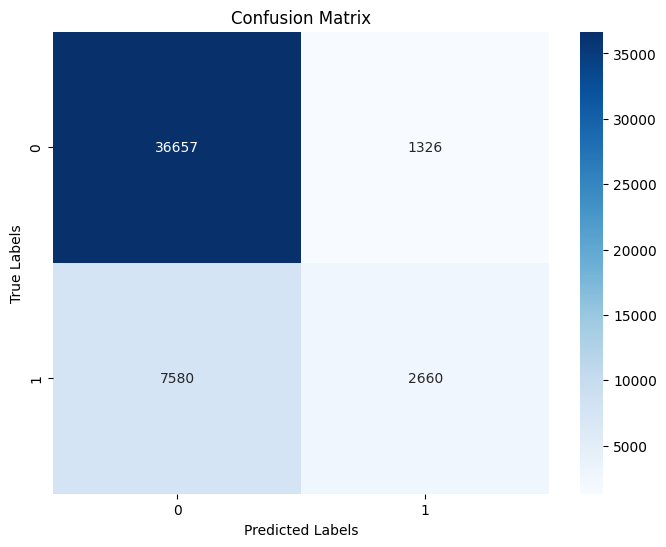

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("Shape of the dataset before train-test split:", datasets.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(datasets1DCNN, labels, test_size=0.2, random_state=42)

# Ensure the training data has the correct shape
print("Shape of X_train:", X_train.shape)
if X_train.shape[1] == 0:
    raise ValueError("The second dimension of the training data is 0, which is invalid for training.")

# Calculate class weights
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model1dcnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    #Dense(1, activation='softmax')
    
])

model1dcnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model1dcnn.summary()

history = model1dcnn.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.3, class_weight=class_weights)


model1dcnnpred = model1dcnn.predict(X_test)

# Evaluate the model on the test set
test_loss, test_accuracy = model1dcnn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")



import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = (model1dcnnpred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [66]:
import os
import pandas as pd

# # Define the directory path
# directory_path = r'D:\LIDARPODS2\SUMMARYSTATS3'

# # Get all CSV files in the directory
# csv_files = [file for file in os.listdir(directory_path) if file.endswith('_30m_wVIIRSDISTDATE_weather.csv')]

# # Combine all CSV files into a single DataFrame
# combined_df = pd.concat([pd.read_csv(os.path.join(directory_path, file)) for file in csv_files])
# combined_df = combined_df[combined_df['label'] != 2]

# # Display the combined DataFrame
# print(combined_df.head())  # Adjust the display as needed

dixieweatherdf = pd.read_csv("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\output_stats_DIXIE_10m_wVIIRSDISTDATE_weather.csv")
dixieweatherdf = dixieweatherdf[dixieweatherdf['label'] != 2]

augustweatherdf = pd.read_csv("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\output_stats_AUGUST_10m_wVIIRSDISTDATE_weather.csv")
augustweatherdf = augustweatherdf[augustweatherdf['label'] != 2]

bearweatherdf = pd.read_csv("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\output_stats_BEAR_10m_wVIIRSDISTDATE_weather.csv")
bearweatherdf = bearweatherdf[bearweatherdf['label'] != 2]

sugarweatherdf = pd.read_csv("C:\\Users\\smdur\\OneDrive\\Desktop\\LidarPods\\SUMMARYSTATS\\output_stats_SUGAR_10m_wVIIRSDISTDATE_weather.csv")
sugarweatherdf = sugarweatherdf[sugarweatherdf['label'] != 2]


combined_df_Weather = pd.concat([dixieweatherdf,augustweatherdf,bearweatherdf,sugarweatherdf])
combined_df_Weather

,label,geometry,midpoint,closest_point_index,closest_LATITUDE,closest_LONGITUDE,closest_BRIGHTNESS,closest_SCAN,closest_TRACK,closest_ACQ_DATE,...,daily_minimum_temperature,daily_maximum_temperature,daily_mean_wind_speed,daily_mean_burning_index_g,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,daily_mean_energy_release_component-g,daily_mean_palmer_drought_severity_index,daily_mean_vapor_pressure_deficit,daily_mean_palmer_z_index
31007,0,LINESTRING (637483.3036906739 4417348.59009151...,POINT (637959.1875 4417502),65377,39.8967,-121.3888,401.7,3.9,1.8,2021-07-14,...,816,837,35,75,39.0,52.0,95,925,248,1220
31008,0,LINESTRING (637641.8296112475 4417108.66308870...,POINT (637962.25 4417492.5),65491,39.8952,-121.3869,329.5,1.4,1.2,2021-07-15,...,794,833,45,82,46.0,53.0,92,937,222,1270
31009,0,LINESTRING (637649.0171112475 4417102.66308870...,POINT (637969.4375 4417486.5),65491,39.8952,-121.3869,329.5,1.4,1.2,2021-07-15,...,794,833,45,82,46.0,53.0,92,937,222,1270
31010,0,LINESTRING (637724.4274420011 4417050.03288931...,POINT (637977.9375 4417481),65491,39.8952,-121.3869,329.5,1.4,1.2,2021-07-15,...,794,833,45,82,46.0,53.0,92,937,222,1270
31011,0,LINESTRING (637732.9274420011 4417045.03288931...,POINT (637986.4375 4417476),65489,39.8998,-121.3829,337.3,1.4,1.2,2021-07-15,...,794,833,45,82,46.0,53.0,92,937,222,1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16172,1,LINESTRING (740068.2580443611 4421540.77082617...,POINT (740527.5 4421738.5),59091,39.9238,-120.1724,374.6,2.2,1.4,2021-07-09,...,780,866,23,59,52.0,71.0,85,1061,261,1425
16173,1,LINESTRING (740072.1330443611 4421531.77082617...,POINT (740531.375 4421729.5),59091,39.9238,-120.1724,374.6,2.2,1.4,2021-07-09,...,780,866,23,59,52.0,71.0,85,1061,261,1425
16174,1,LINESTRING (740075.9455443611 4421522.27082617...,POINT (740535.1875 4421720),60147,39.9193,-120.1666,322.5,1.4,1.2,2021-07-10,...,798,876,30,65,53.0,69.0,85,1061,275,1425
16175,1,LINESTRING (740079.8205443611 4421513.27082617...,POINT (740539.0625 4421711),60147,39.9193,-120.1666,322.5,1.4,1.2,2021-07-10,...,798,876,30,65,53.0,69.0,85,1061,275,1425


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# Assuming combined_df is already loaded and contains the data with features and 'label' column

# Define the columns to use for training
# selected_columns = ['SLOPE_75thPercentile', 'TRI_Mean', 'TRI_Median', 'TRI_StdDev', 'TRI_Min', 'TRI_Max',
#                     'TRI_25thPercentile', 'TRI_50thPercentile', 'TRI_75thPercentile', 'DTM_Mean', 'DTM_Median',
#                     'DTM_StdDev', 'DTM_Min', 'DTM_Max', 'DTM_25thPercentile', 'DTM_50thPercentile',
#                     'DTM_75thPercentile']

selected_columns = [ 'TRI_Mean', 'TRI_Median', 'TRI_StdDev', 'TRI_Min', 'TRI_Max']

# Split the DataFrame into features (X) and labels (y)
X = combined_df_Weather[selected_columns]
y = combined_df_Weather['label']

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Build the MLP model
# modelMLP = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train2.shape[1],)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')  # Binary classification output
# ])

modelMLP = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train2.shape[1],)),
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='relu')
])


# Compile the model
modelMLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight

y_train2 = np.array(y_train2)

# Calculate class weights
classes = np.unique(y_train2)
weights = compute_class_weight('balanced', classes=classes, y=y_train2)
class_weights = dict(zip(classes, weights))
print(len(classes))
# # Train the model with class weights
modelMLP.fit(X_train2, y_train2, epochs=1, batch_size=256, validation_split=0.2, class_weight=class_weights)


modelMLPpred = modelMLP.predict(X_test2)

# # Evaluate the model
# loss, accuracy = modelMLP.evaluate(X_test2, y_test2)
# print("MLP Model Accuracy:", accuracy)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = (modelMLPpred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test2, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

C:\Users\smdur\anaconda3\envs\lidarpods\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6422 - loss: 0.7999 - val_accuracy: 0.7206 - val_loss: 0.6195
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step


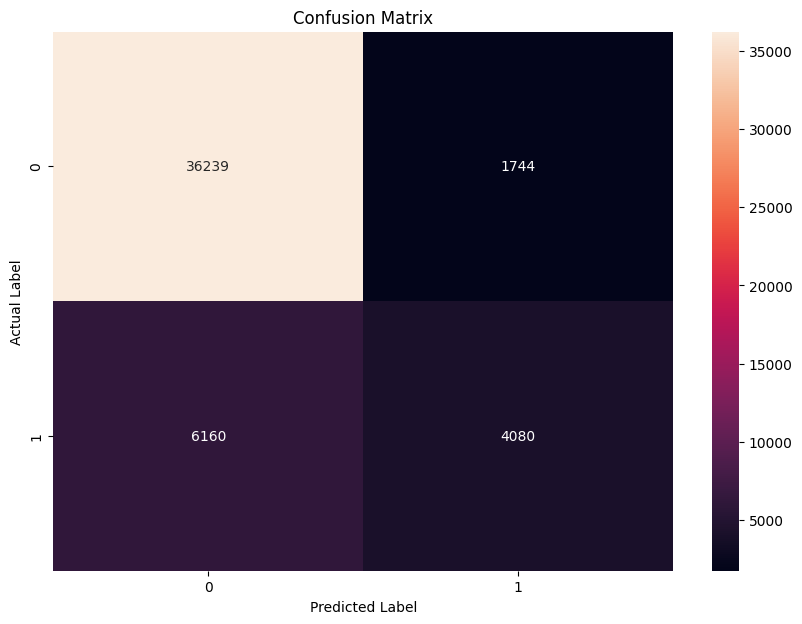

In [78]:

import numpy as np
from sklearn.linear_model import LogisticRegression

# Assume model1 and model2 are your trained models
#probabilities_model1 = model1.predict(input_data_1dcnn)  # Predict with the 1D CNN model
#probabilities_model2 = model2.predict(input_data_weather)  # Predict with the weather model

# Concatenating the prediction probabilities from both models
combined_features = np.concatenate([model1dcnnpred, modelMLPpred], axis=1)
train_labels = y_test2

# Train a meta-learner model on the combined features
meta_learner = LogisticRegression()
meta_learner.fit(combined_features, train_labels)

# Use the meta-learner for final predictions
final_predictions = meta_learner.predict(combined_features)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `train_labels` are the true labels for the data on which `final_predictions` were made
conf_matrix = confusion_matrix(train_labels, final_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [75]:
# Assuming you already have a valid split for CNN and MLP data
# X_train, X_test from datasets1DCNN (for CNN)
# X_train2, X_test2 from combined_df_Weather (for MLP)

# Train both models (assuming they are already compiled)
history_cnn = model1dcnn.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.3, class_weight=class_weights)
history_mlp = modelMLP.fit(X_train2, y_train2, epochs=2, batch_size=64, validation_split=0.3, class_weight=class_weights)

# Generate predictions for the same validation set split (ensure this is done correctly)
preds_cnn_train = model1dcnn.predict(X_train)
preds_mlp_train = modelMLP.predict(X_train2)

# Stack predictions
stacked_features_train = np.column_stack((preds_cnn_train, preds_mlp_train))

# You must ensure that `y_train` and `y_train2` are actually the same and correctly aligned
# This is crucial for training the stacker model


Epoch 1/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7461 - loss: 0.5945 - val_accuracy: 0.8272 - val_loss: 0.5213
Epoch 2/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7576 - loss: 0.5793 - val_accuracy: 0.8225 - val_loss: 0.5027
Epoch 1/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7341 - loss: 0.5474 - val_accuracy: 0.7369 - val_loss: 0.5331
Epoch 2/2
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7344 - loss: 0.5512 - val_accuracy: 0.7420 - val_loss: 0.5312
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 3s 460us/step


In [76]:
# Assuming y_train and y_train2 are the same and properly aligned
stacker = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(2,)),
    layers.Dense(1, activation='sigmoid')
])
stacker.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
stacker.fit(stacked_features_train, y_train, epochs=10, batch_size=32)  # Use y_train or y_train2 assuming they are identical


Epoch 1/10


C:\Users\smdur\anaconda3\envs\lidarpods\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 591us/step - accuracy: 0.8426 - loss: 0.3746
Epoch 2/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 5s 851us/step - accuracy: 0.8607 - loss: 0.3309
Epoch 3/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 700us/step - accuracy: 0.8620 - loss: 0.3285
Epoch 4/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 5s 757us/step - accuracy: 0.8616 - loss: 0.3278
Epoch 5/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 726us/step - accuracy: 0.8625 - loss: 0.3273
Epoch 6/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 661us/step - accuracy: 0.8624 - loss: 0.3268
Epoch 7/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 720us/step - accuracy: 0.8623 - loss: 0.3259
Epoch 8/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 646us/step - accuracy: 0.8625 - loss: 0.3264
Epoch 9/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 663us/step - accuracy: 0.8646 - loss: 0.3244
Epoch 10/10
6028/6028 ━━━━━━━━━━━━━━━━━━━━ 4s 604us/step - accuracy: 0.8615 - loss: 0.3284


1507/1507 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step


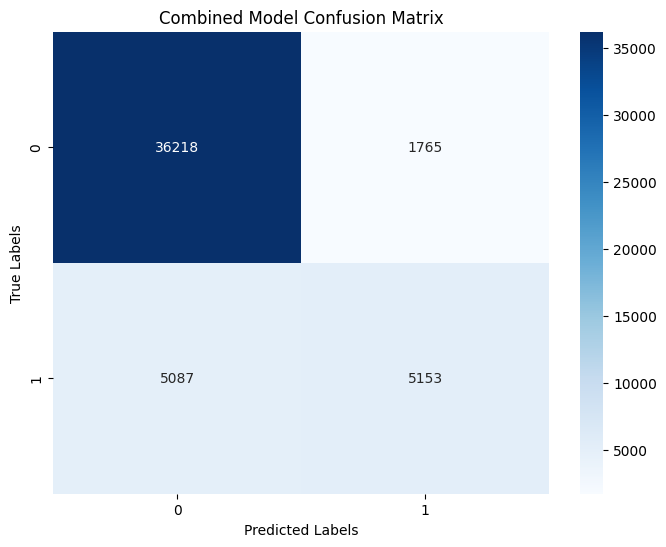

In [77]:
# Generate predictions for the test set
preds_cnn_test = model1dcnn.predict(X_test)
preds_mlp_test = modelMLP.predict(X_test2)

# Stack test predictions
stacked_features_test = np.column_stack((preds_cnn_test, preds_mlp_test))

# Final predictions
final_preds = stacker.predict(stacked_features_test)
final_binary_preds = (final_preds > 0.5).astype(int)

# Evaluate
cm = confusion_matrix(y_test, final_binary_preds)  # Ensure y_test is correctly aligned with these predictions
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Combined Model Confusion Matrix')
plt.show()


2
Epoch 1/10


C:\Users\smdur\anaconda3\envs\lidarpods\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4823/4823 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6539 - loss: 0.6953 - val_accuracy: 0.6838 - val_loss: 0.5669
Epoch 2/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6638 - loss: 0.6151 - val_accuracy: 0.6817 - val_loss: 0.5557
Epoch 3/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6782 - loss: 0.5846 - val_accuracy: 0.6682 - val_loss: 0.5750
Epoch 4/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6887 - loss: 0.5908 - val_accuracy: 0.7142 - val_loss: 0.5636
Epoch 5/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7053 - loss: 0.5669 - val_accuracy: 0.6894 - val_loss: 0.5745
Epoch 6/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7126 - loss: 0.5814 - val_accuracy: 0.7078 - val_loss: 0.5348
Epoch 7/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7140 - loss: 0.5795 - val_accuracy: 0.7219 - val_loss: 0.5467
Epoch 8/10
4823/4823 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7188 - loss: 0.5662 - val_accurac

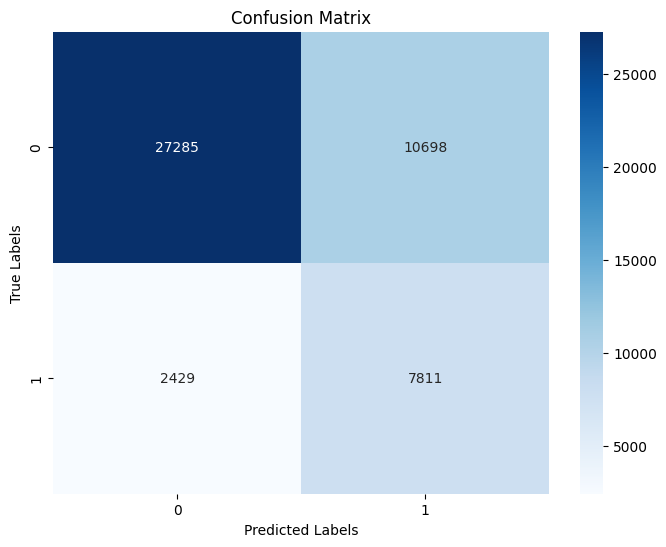

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# Assuming combined_df is already loaded and contains the data with features and 'label' column

# Define the columns to use for training
# selected_columns = ['SLOPE_75thPercentile', 'TRI_Mean', 'TRI_Median', 'TRI_StdDev', 'TRI_Min', 'TRI_Max',
#                     'TRI_25thPercentile', 'TRI_50thPercentile', 'TRI_75thPercentile', 'DTM_Mean', 'DTM_Median',
#                     'DTM_StdDev', 'DTM_Min', 'DTM_Max', 'DTM_25thPercentile', 'DTM_50thPercentile',
#                     'DTM_75thPercentile']

selected_columns = [ 'daily_mean_burning_index_g', 'dead_fuel_moisture_1000hr', 'daily_mean_vapor_pressure_deficit', 
                    'daily_mean_specific_humidity', 'TRI_Max']

# Split the DataFrame into features (X) and labels (y)
X = combined_df_Weather[selected_columns]
y = combined_df_Weather['label']

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Build the MLP model
# modelMLP = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train2.shape[1],)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')  # Binary classification output
# ])

modelMLP2 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train2.shape[1],)),
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Added dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='relu')
])


# Compile the model
modelMLP2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight

y_train2 = np.array(y_train2)

# Calculate class weights
classes = np.unique(y_train2)
weights = compute_class_weight('balanced', classes=classes, y=y_train2)
class_weights = dict(zip(classes, weights))
print(len(classes))
# # Train the model with class weights
modelMLP2.fit(X_train2, y_train2, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)


modelMLPpred2 = modelMLP2.predict(X_test2)

# # Evaluate the model
# loss, accuracy = modelMLP.evaluate(X_test2, y_test2)
# print("MLP Model Accuracy:", accuracy)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = (modelMLPpred2 > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test2, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()